16×1 Matrix{ComplexF64}:
     0.790310624644917 - 0.11672287407054682im
    0.8333635562451901 - 2.0373782065398274im
   -1.8483359652328226 - 0.4910678477618664im
 3.317957213772549e-14 - 5.335908024990568e-16im
    0.5808767225971678 - 0.8831911464367295im
    -2.118042469024658 - 2.3448963165283203im
    -2.161755815621291 + 1.824810893915128im
   0.16992265871889778 + 0.690698411786947im
  0.008633926656330004 - 0.4005389839876443im
    -2.123296312779239 + 0.3448409291970703im
    0.4154916212804405 + 1.8358976499721198im
    0.5873363297131284 + 0.3266533083656631im
   0.29706061266369943 - 0.10151444842995261im
    0.2641773223876953 + 0.6117630004882812im
   0.16520968211261788 - 0.43901669260230847im
     0.496575967084556 + 0.10336208207385622im

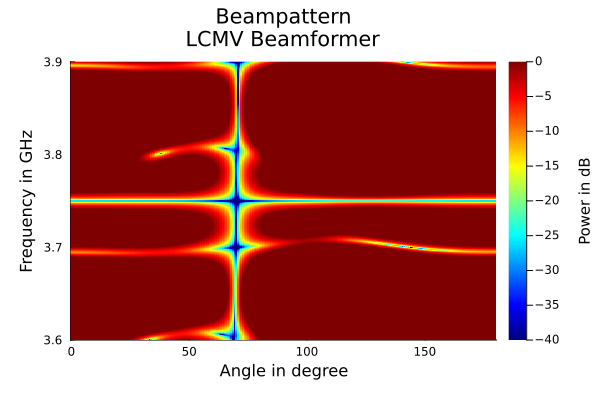

In [26]:
using ArraySignalProcessing
pa = TappedDelayLine(IsotropicArrayManifold(-6e-2, -2e-2, 2e-2, 6e-2), 4, 200e6)

# Use the array below to better see the behaviour
#pa = IsotropicArray(Vector(LinRange(-20e-2, 20e-2, 16)))

# Diagonal loading is applied by adding whitenoise to the correlation matrix
Snn = diffnoise(pa, 1e-6, 3.75e9) + whitenoise(pa, 1e-4, 3.75e9)

# Constraints C set for two directions and 4 freqeuncy bands (as we set 4 taps)
C = steer(pa, deg2rad.([30 70]), [3.76e9, 3.7e9, 3.8e9, 3.9e9])

# Gains; four times repeated for the 4 frequencies
# the consstrains are set for
G = repeat([1, 0], 4, 1)

weights = lcmv_weights(Snn, C, G)
display(weights)

faxis = LinRange(3.6e9, 3.9e9, 1024)
ϕaxis = LinRange(0, 180, 256)
A = steer.(Ref(pa), Ref(deg2rad.(ϕaxis)), faxis)
W = reduce(vcat, Ref(weights') .* A)
WdB = 20*log10.(abs.(W))

using Plots
import Measures
p1 = heatmap(ϕaxis, faxis/1e9, WdB, cmap = :jet, clim=(-40, 0))
plot!(title="Beampattern\nLCMV Beamformer", cbar_title="\nPower in dB", margin=5*Measures.mm)
xlabel!("Angle in degree")
ylabel!("Frequency in GHz")

display(p1)

16×1 CuArray{ComplexF32, 2, CUDA.DeviceMemory}:
  4.4825897f0 - 24.760696f0im
 -49.064575f0 - 5.4000244f0im
 -13.825195f0 + 46.72354f0im
  22.843262f0 + 3.8458252f0im
 -19.237122f0 - 36.355865f0im
  -68.34558f0 + 42.225098f0im
  28.646545f0 + 73.63504f0im
  33.156494f0 - 17.67627f0im
 -30.665741f0 - 12.270752f0im
 -20.310078f0 + 61.440132f0im
  56.044846f0 + 30.852982f0im
  11.427521f0 - 28.269135f0im
 -6.7460136f0 - 1.2094059f0im
 -1.5075073f0 + 13.473389f0im
  12.772995f0 + 3.7637787f0im
   1.041626f0 - 6.2614746f0im

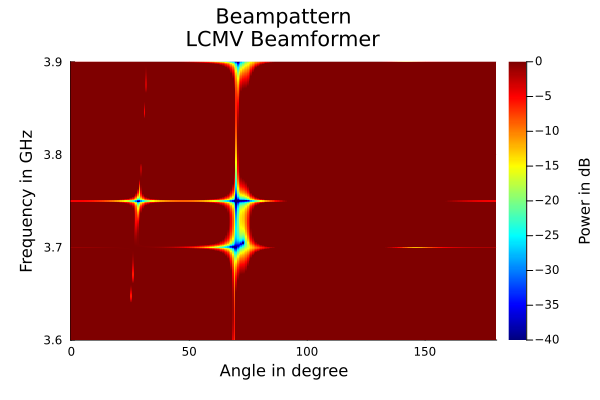

In [33]:
using ArraySignalProcessing
using CUDA
pa = TappedDelayLine(IsotropicArrayManifold(cu([-6e-2, -2e-2, 2e-2, 6e-2])), 4, 200e6)

# Use the array below to better see the behaviour
#pa = IsotropicArray(Vector(LinRange(-20e-2, 20e-2, 16)))

# Diagonal loading is applied by adding whitenoise to the correlation matrix
Snn = diffnoise(pa, 1e-6, 3.75e9) + whitenoise(pa, 1e-4, 3.75e9)

# Constraints C set for two directions and 4 freqeuncy bands (as we set 4 taps)
C = steer(pa, cu(deg2rad.([30 70])), Float32.([3.76e9, 3.7e9, 3.8e9, 3.9e9]))
# Gains; four times repeated for the 4 frequencies
# the consstrains are set for
G = repeat([1, 0], 4, 1)

weights = lcmv_weights(cu(Snn), C, cu(G))
display(weights)

faxis = LinRange(3.6e9, 3.9e9, 1024)
ϕaxis = LinRange(0, 180, 256)
#A = steer.(Ref(pa), Ref(cu(collect(deg2rad.(ϕaxis)))), faxis)
#W = reduce(vcat, Ref(weights') .* A)
A = steer(pa, cu(deg2rad.(ϕaxis)), faxis)
W = transpose(reshape(weights' * A, :, length(faxis)))
WdB = 20*log10.(abs.(W))

using Plots
import Measures
p1 = heatmap(ϕaxis, faxis/1e9, Array(WdB), cmap = :jet, clim=(-40, 0))
plot!(title="Beampattern\nLCMV Beamformer", cbar_title="\nPower in dB", margin=5*Measures.mm)
xlabel!("Angle in degree")
ylabel!("Frequency in GHz")

display(p1)